# `qubit_discovery` Transmon Optimization

Here, we use `qubit_discovery` to optimize a flux-tunable transmon for a specific target frequency $\omega_{01}^*$, long $T_2$ time, and high anharmonicity. The point of this notebook is to show an entire workflow start-to-end; see the other tutorial notebooks for more details about the different functions used.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import qubit_discovery as qd
import SQcircuit as sq

1. Initialize a sampler to randomly sample circuits from allowed element ranges.

In [2]:
# Switch to the PyTorch engine
sq.set_engine('PyTorch')

# Construct circuit sampler
sampler = qd.optimization.CircuitSampler(
    capacitor_range=[1e-15, 12e-12],    # in F
    inductor_range=[1e-15, 5e-6],       # in H
    junction_range=[1e9, 100e9],        # in Hz
    flux_range=[0, 1]                   # in units of Phi0
)

2. Construct loss function, using some built-in and some custom metrics. We'll optimize for
- A target qubit frequency of 6.5 GHz (custom metric)
- Low sensitivity to external flux and charge
- Long $T_2$ times and large anharmonicity $\mathcal{A}$. This is captured in a metric `'number_of_gates'` $\mathcal{N} = \mathcal{A}T_2$, which represents a bound on the number of single-qubit gates which can be performed.

In [3]:
# Construct a custom metric function for target frequency
TARGET_FREQUENCY = 6.5

def target_freq_loss(circuit):
    circuit_freq = circuit.efreqs[1] - circuit.efreqs[0]

    loss = ((circuit_freq - TARGET_FREQUENCY)/TARGET_FREQUENCY)**2
    return loss, circuit_freq

qd.losses.add_to_metrics('target_frequency', target_freq_loss)


# Build total loss function 
my_loss_function = qd.losses.build_loss_function(
    use_losses = { # setting all weights equal for this example
        'target_frequency': 1.0,
        'number_of_gates': 1.0,
        'charge_sensitivity': 1.0,
        'flux_sensitivity': 1.0
    },
    use_metrics = ['t1', 't_phi'] # interesting to track T1 and T_phi
)

3. Perform the optimization. Because gradient descent can get stuck in local minima, we run optimization 20 times with different random initializations.

In [4]:
optimized_circuits = []
loss_records = []
metric_records = []

for i in range(20):
    print(f'Optimizing circuit #{i+1}')
    circuit = sampler.sample_circuit_code('JJ')
    final_circuits, loss_results, metric_results = qd.optimization.run_BFGS(
        circuit = circuit,
        loss_metric_function  = my_loss_function,
        max_iter = 50,
        total_trunc_num = 50,
        bounds = sampler.bounds,
    )

    # The output of the optimization is the optimized circuit and a record
    # of the loss and calculated metrics at each step. We save those
    optimized_circuits.append(final_circuits)
    loss_records.append(loss_results)
    metric_records.append(metric_results)

Optimizing circuit #1


Iteration 23:  46%|████▌     | 23/50 [00:25<00:30,  1.12s/it, loss=7.523e-05]


Optimizing circuit #2


Iteration 13:  26%|██▌       | 13/50 [00:24<01:09,  1.89s/it, loss=7.083e-05]


Optimizing circuit #3


Iteration 42:  84%|████████▍ | 42/50 [01:10<00:13,  1.68s/it, loss=3.581e-05]


Optimizing circuit #4


Iteration 19:  38%|███▊      | 19/50 [00:22<00:37,  1.19s/it, loss=8.545e-05]


Optimizing circuit #5


Iteration 18:  36%|███▌      | 18/50 [00:27<00:49,  1.54s/it, loss=4.896e-05]


Optimizing circuit #6


Iteration 27:  54%|█████▍    | 27/50 [00:32<00:27,  1.20s/it, loss=5.889e-05]


Optimizing circuit #7


Iteration 18:  36%|███▌      | 18/50 [00:17<00:31,  1.01it/s, loss=2.141e-04]


Optimizing circuit #8


Iteration 29:  58%|█████▊    | 29/50 [00:43<00:31,  1.49s/it, loss=7.265e-05]


Optimizing circuit #9


Iteration 16:  32%|███▏      | 16/50 [00:34<01:13,  2.15s/it, loss=2.616e-05]


Optimizing circuit #10


Iteration 44:  88%|████████▊ | 44/50 [00:57<00:07,  1.30s/it, loss=2.314e-05]


Optimizing circuit #11


Iteration 7:  14%|█▍        | 7/50 [00:10<01:07,  1.56s/it, loss=5.360e-04]


Optimizing circuit #12


Iteration 30:  60%|██████    | 30/50 [00:32<00:21,  1.08s/it, loss=2.144e-05]


Optimizing circuit #13


Iteration 22:  44%|████▍     | 22/50 [00:36<00:46,  1.66s/it, loss=4.698e-05]


Optimizing circuit #14


Iteration 26:  52%|█████▏    | 26/50 [00:27<00:25,  1.04s/it, loss=1.861e-05]


Optimizing circuit #15


Iteration 27:  54%|█████▍    | 27/50 [00:35<00:29,  1.30s/it, loss=2.860e-05]


Optimizing circuit #16


Iteration 17:  34%|███▍      | 17/50 [00:17<00:33,  1.02s/it, loss=2.431e-05]


Optimizing circuit #17


Iteration 39:  78%|███████▊  | 39/50 [00:58<00:16,  1.51s/it, loss=2.017e-05]


Optimizing circuit #18


Iteration 18:  36%|███▌      | 18/50 [00:44<01:18,  2.45s/it, loss=9.157e-05]


Optimizing circuit #19


Iteration 12:  24%|██▍       | 12/50 [00:18<00:58,  1.54s/it, loss=3.661e-05]


Optimizing circuit #20


Iteration 14:  28%|██▊       | 14/50 [00:14<00:36,  1.00s/it, loss=4.741e-05]


4. We can now look at the best-performing optimizations. Let's start by plotting the learning curve of some of the runs.

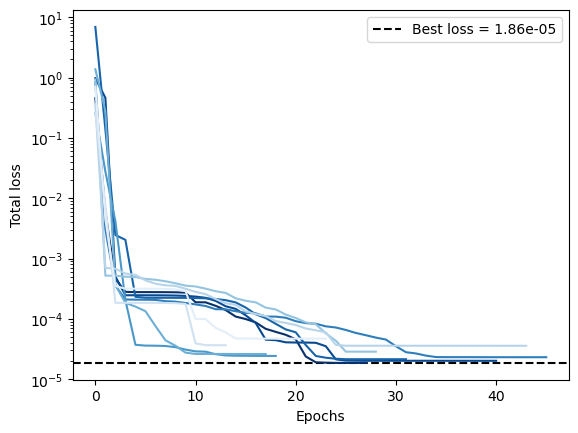

In [9]:
# Get indices of best runs (sorted by final total loss)
best_runs = sorted(np.arange(len(loss_records)),
                   key = lambda i: loss_records[i]['total_loss'][-1])

# Plot best 10 optimizations
norm = matplotlib.colors.Normalize(vmin=0, vmax=10) 
sm = matplotlib.cm.ScalarMappable(cmap=matplotlib.colormaps['Blues_r'], norm=norm)  
for i, run_idx in enumerate(best_runs[:10]):
    rec = loss_records[run_idx]
    if i == 0:
        best_loss = rec['total_loss'][-1]
        plt.axhline(best_loss, label=f'Best loss = {best_loss:.2e}', c='k', linestyle='--')
    plt.semilogy(rec['total_loss'], c=sm.to_rgba(i))
    
plt.xlabel('Epochs')
plt.ylabel('Total loss')
plt.legend()

And now look at the details of the best circuit.

In [10]:
best_circuit = optimized_circuits[best_runs[0]]
best_loss_record = loss_records[best_runs[0]]
best_metrics_record = metric_records[best_runs[0]]

best_circuit.description()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, 'Qubit frequency')

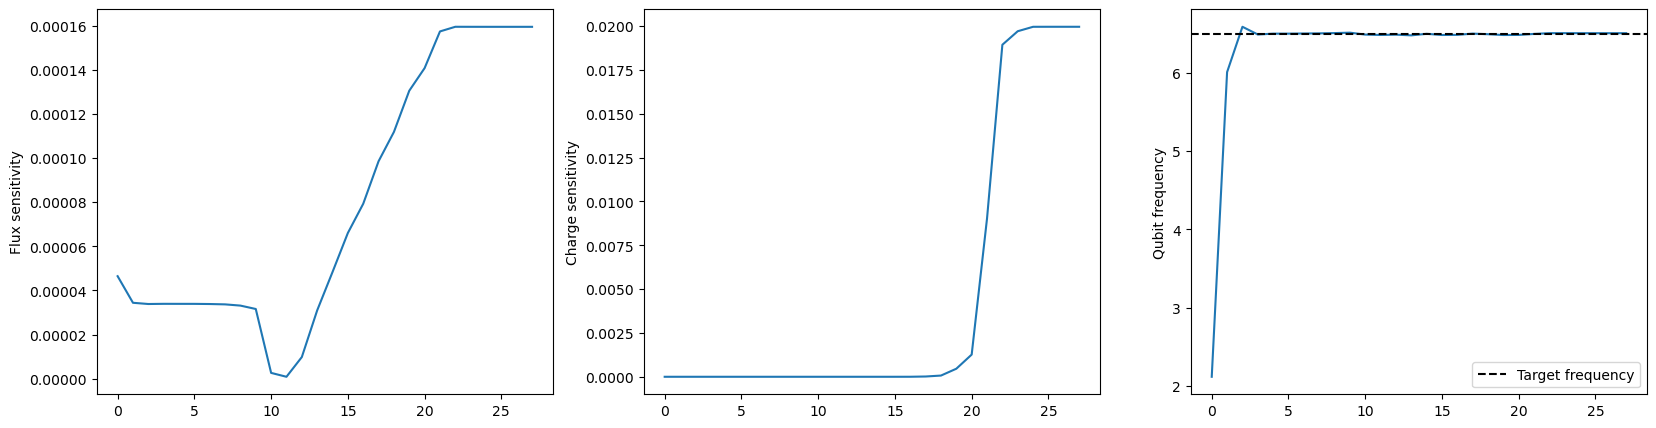

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(metric_records[best_runs[0]]['flux_sensitivity'])
ax[0].set_ylabel('Flux sensitivity')
ax[1].plot(metric_records[best_runs[0]]['charge_sensitivity'])
ax[1].set_ylabel('Charge sensitivity')
ax[2].plot(metric_records[best_runs[0]]['target_frequency'])
ax[2].axhline(TARGET_FREQUENCY, label='Target frequency', c='k', linestyle='--')
ax[2].legend()
ax[2].set_ylabel('Qubit frequency')